# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/access/code


In [2]:
from mobilkit.umni import *

In [3]:
import contextily as ctx

## 1.1. Load data

### 1.1.1. Zones (TIGER)

In [4]:
zones = gpd.read_parquet('../data/zones/in_2010.parquet').set_crs(CRS_DEG).disp(0)

6,417 rows x 6 cols; Memory: 1.3 MiB; CRS: EPSG:4326


,geoid,scale,county,aland,awater,geometry
,<object>,<object>,<object>,<int64>,<int64>,<geometry>


### 1.1.2. Census (ACS)

In [5]:
acs = pd.read_parquet('../data/ses/acs_in_2019.parquet').disp(0)

6,407 rows x 25 cols; Memory: 1.9 MiB


,scale,geoid,popu,pop_density,p_minor,p_poc,p_lowedu,m_income,p_pov,p_pov150,p_pov200,p_snap,p_unemploy,p_noinsur,p_disabled,p_lowenglish,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>


### 1.1.3. POIs (SafeGraph)

In [6]:
pois = gpd.read_parquet('../data/pois/pois_in.parquet').set_crs(CRS_DEG).disp(0)

80,742 rows x 8 cols; Memory: 24.9 MiB; CRS: EPSG:4326


,id,purpose,kind,sg_category,geometry,area,visits,visitors
,<object>,<object>,<object>,<object>,<geometry>,<float64>,<int32>,<int32>


### 1.1.4. OD distances
<!-- Convert distances from unidirectional to bidirectional. -->

In [7]:
od = pd.read_parquet('../../spr_4711/data/distance/travel_times.parquet')
same = (od.groupby(['scale', 'mode', 'source']).size().reset_index()
        .assign(target=lambda df: df.source).assign(time=0).drop(columns=0))
od = pd.concat([od, same]).reset_index(drop=1).astype(D(time=np.float32) | {
    x: CAT for x in ['source', 'target', 'mode', 'scale']}).disp()

7,697,672 rows x 5 cols; Memory: 74.8 MiB


,source,target,time,scale,mode
,<category>,<category>,<float32>,<category>,<category>
0,18051,18083,1931.0,COUNTY,DRIVE


### 1.1.5. Impedance function

In [8]:
imped_params = (
    pd.read_csv('../data/nhts/fitted-params-power-exponential.csv')
    .query('measure == "Duration" & parameter != "r2"')
    .assign(purpose=lambda df: df.purpose.str.replace('Other', 'Services'))
    .assign(mode=lambda df: df['mode'].str.upper())
).disp()

38 rows x 5 cols; Memory: 0.0 MiB


,measure,mode,purpose,parameter,value
,<object>,<object>,<object>,<object>,<float64>
0,Duration,BIKE,Overall,alpha,0.025914


# 2. Accessibility measure

## 2.1. Non-work (POI) access

In [9]:
def get_poi_access(zones=zones, acs=acs, pois=pois, od=od, 
                   imped_params=imped_params, 
                   thresholds=(15, 30, 45, 60, 90),
                   wt_method='count', overwrite=False):
    """Compute the proposed accessibility to POIs per person 
    for all the zones.

    Parameters
    ----------
    zones : GeoDataFrame
        Table of zones at different scales.
    acs : DataFrame
        Census data table containing the population column `popu`.
    pois : GeoDataFrame
        Table of POIs classified by `purpose` and `kind`.
    od : DataFrame
        Table having distance/travel time value for each zone OD pair.
    imped_params : DataFrame
        Table containing the power exponential impedance 
        function parameters α and β.
    thresholds : arraylike[float]
        Travel time thresholds (in minutes).
    wt_method : str
        Method to weight POI attractiveness; one of 
        {"count", "area", "visits"}.
        TODO: Add support for "area" and "visits".
    eps : float
        A small tolerance value to avoid division by zero error.

    Returns
    -------
    Pdf
        Table containing POI accessibility value for each zone
    """
    outpath = Path('../data/access/poi_access.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    zones = zones.merge(acs, on='geoid')[['geoid', 'popu', 'geometry']]
    pois = pois.sjoin(zones[['geoid', 'geometry']], predicate='within')
    pois = (pois.groupby(['geoid', 'purpose', 'kind'])
            .agg(D(count=D(id='count'), visits=D(visits=sum), 
                   area=D(area=sum))[wt_method])
            .iloc[:, 0].rename('opport').reset_index())
    params = imped_params.query('purpose != "Work"')
    res = []
    pbar = tqdm(total=4 * 4 * len(thresholds)) # modes x purposes x thresh
    for mode, d1 in od.groupby('mode', sort=False): # each mode
        for thresh in thresholds: # each threshold
            coef = (params[params['mode'] == mode]
                    .pivot_table('value', 'purpose', 'parameter'))
            for purpose, d2 in coef.iterrows(): # each purpose
                pbar.update()
                pbar.set_description('purpose={}, mode={}, thresh={} min'
                                     .format(mode.title(), purpose, thresh))
                time = (d1[d1['time'] / 60 <= thresh]
                        .set_index(['source', 'target'])
                        ['time'].rename('weight') / 60)
                wtd = np.exp(-d2.alpha * time ** d2.beta)
                unwtd = Seq(1, name='weight', index=wtd.index)
                wt = pd.concat([wtd.reset_index().assign(wt_decay=True),
                                unwtd.reset_index().assign(wt_decay=False)])
                wt = wt.merge(pois, left_on='target', right_on='geoid')
                wt = wt.astype(D(source=str))
                wt['access'] = wt['opport'] * wt['weight']
                df = (wt.groupby(['source', 'wt_decay'])['access'].sum()
                      .reset_index().assign(kind='Overall'))
                if purpose != 'Overall':
                    df2 = (wt[wt['purpose'] == purpose]
                           .groupby(['source', 'kind', 'wt_decay'])
                           ['access'].sum().reset_index())
                    df = pd.concat([df, df2])
                df = df.rename(columns=D(source='geoid'))
                res.append(df.assign(purpose=purpose, mode=mode, thresh=thresh))
    grp_cols = ['purpose', 'kind', 'mode', 'thresh', 'geoid']
    xs = (pd.concat(res).reset_index(drop=True)
          .rename(columns=D(source='geoid'))
          .merge(zones[['geoid', 'popu']], on='geoid')
          .astype(D(thresh=str)).astype({x: CAT for x in grp_cols}))
    xs_pp = xs.assign(per_person=True, access=xs['access'] / xs['popu'])
    xs = (pd.concat([xs.assign(per_person=False), xs_pp])
          .reset_index(drop=True).astype(D(access=np.float32))
          [grp_cols + ['wt_decay', 'per_person', 'access']])
    xs.to_parquet(U.mkfile(outpath))
    return xs

xs = get_poi_access(overwrite=0).disp() # t=7:51
# xs = get_poi_access(overwrite=1); xs

5,370,400 rows x 8 cols; Memory: 62.1 MiB


,purpose,kind,mode,thresh,geoid,wt_decay,per_person,access
,<category>,<category>,<category>,<category>,<category>,<bool>,<bool>,<float32>
0,Overall,Overall,DRIVE,15,18001,False,False,1353.0


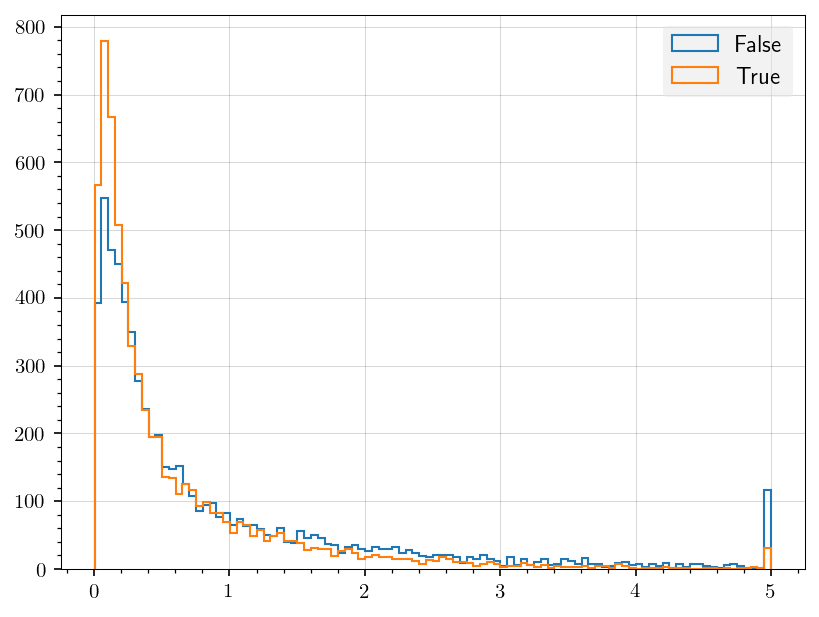

In [10]:
df = xs.query('per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"')
(df.assign(x=df.access.clip(0, 5))
 .groupby(['wt_decay']).x.hist(bins=100, histtype='step', legend=True));

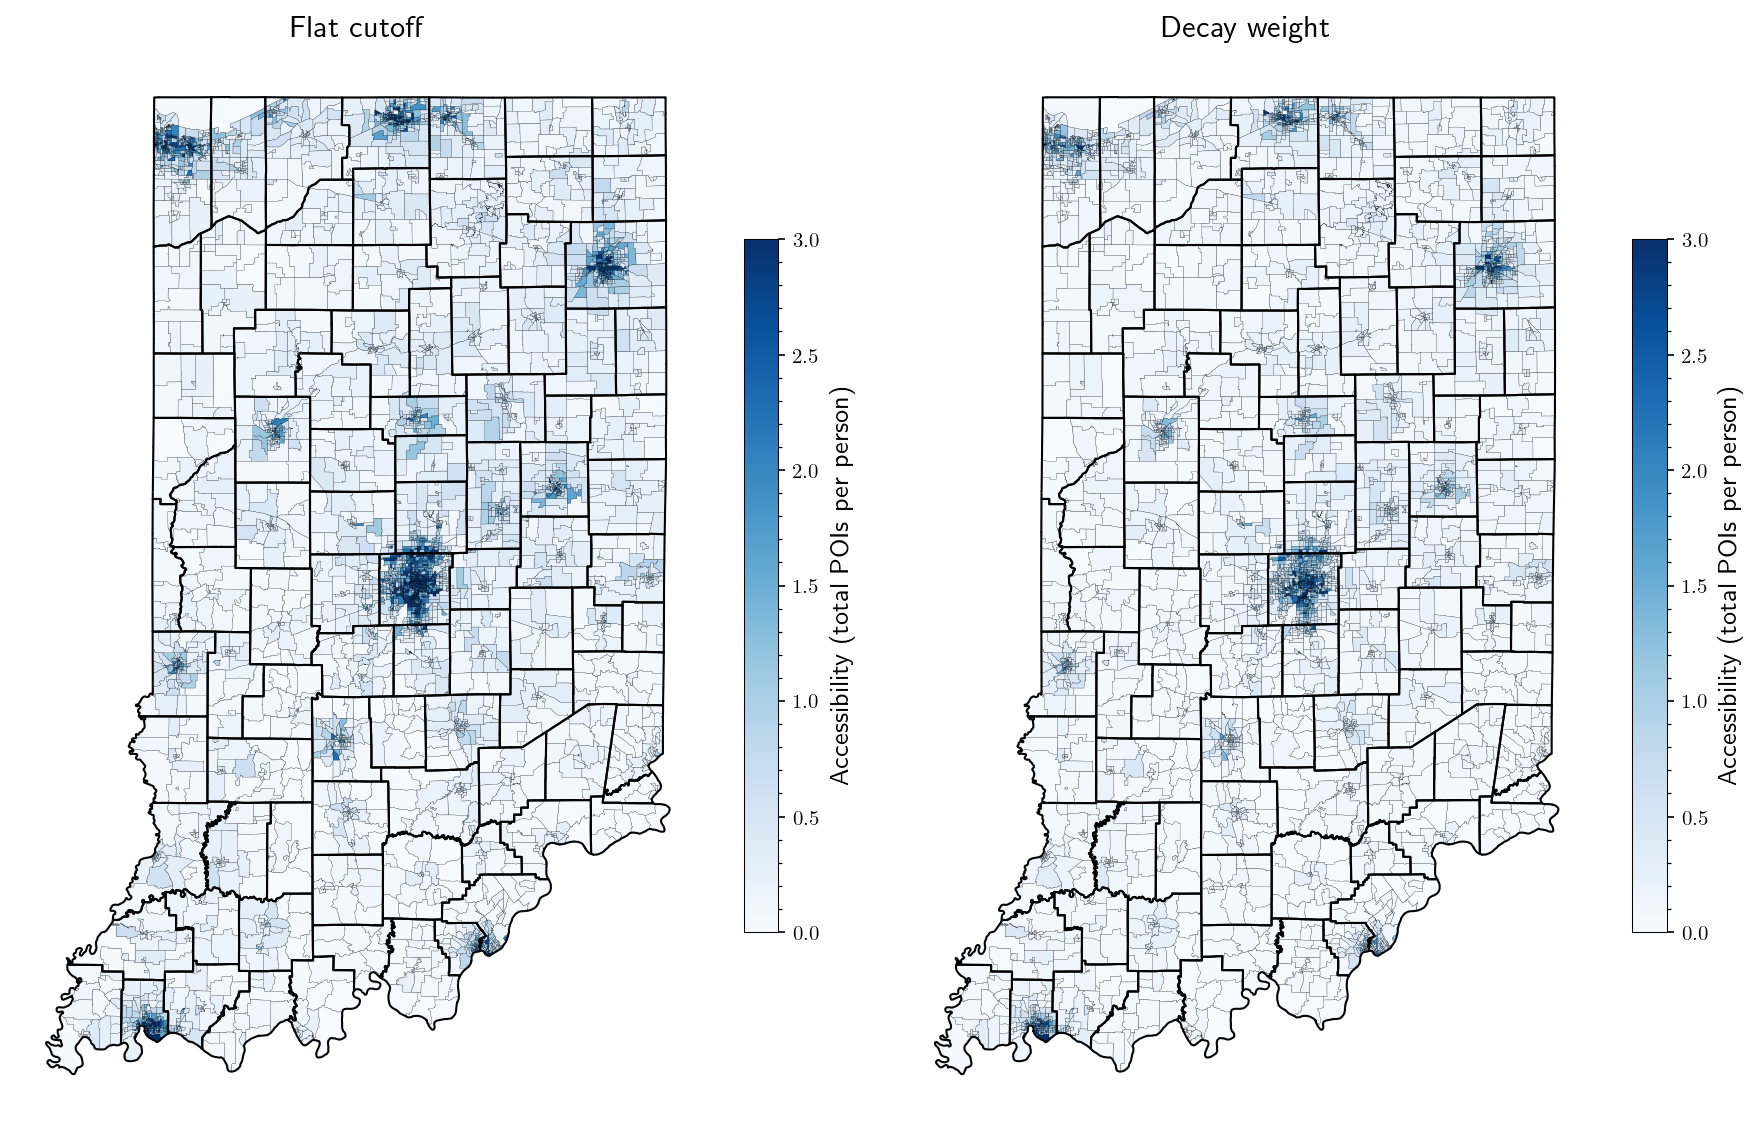

In [11]:
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones[['geoid','geometry','scale']]
                             .merge(df, on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='Blues',
                         vmin=0, vmax=3, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
plt.tight_layout()

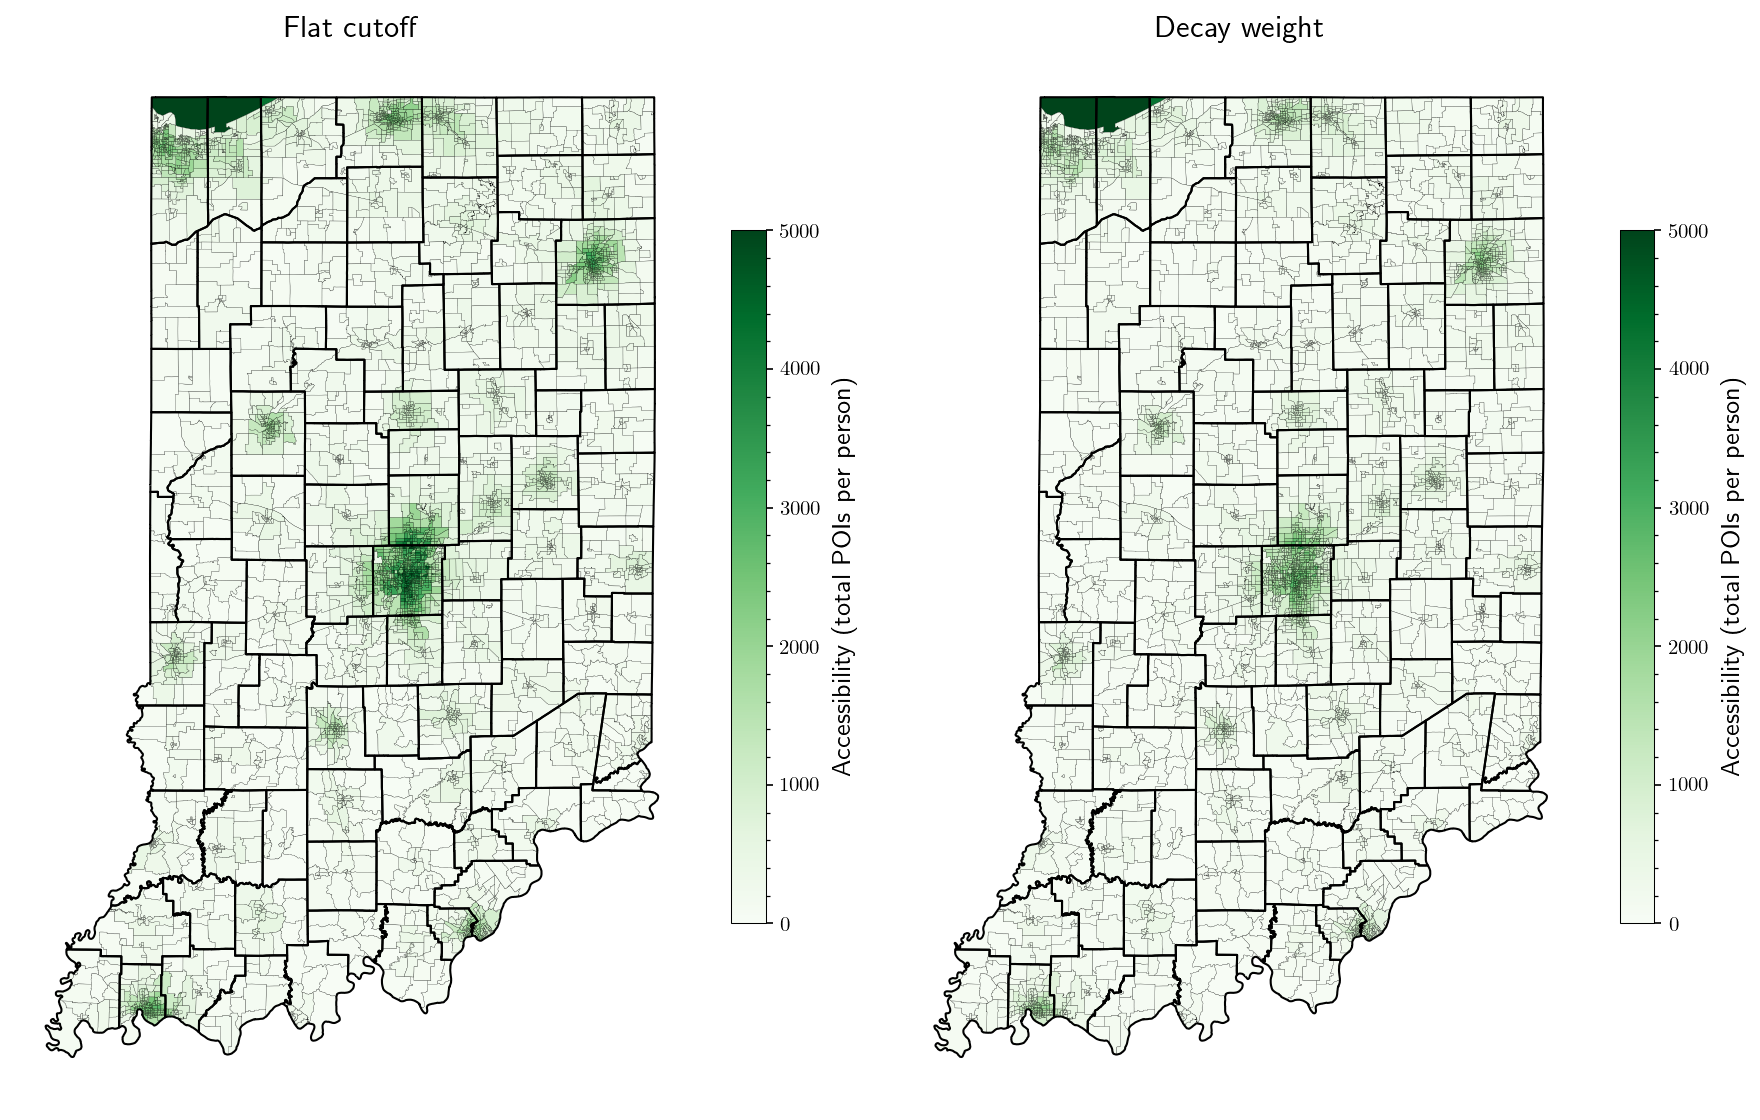

In [12]:
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones[['geoid','geometry','scale']]
                             .merge(xs.query('~per_person & mode=="DRIVE" & thresh=="15" & purpose=="Overall"'), 
                                    on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='Greens',
                         vmin=0, vmax=5e3, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
plt.tight_layout()

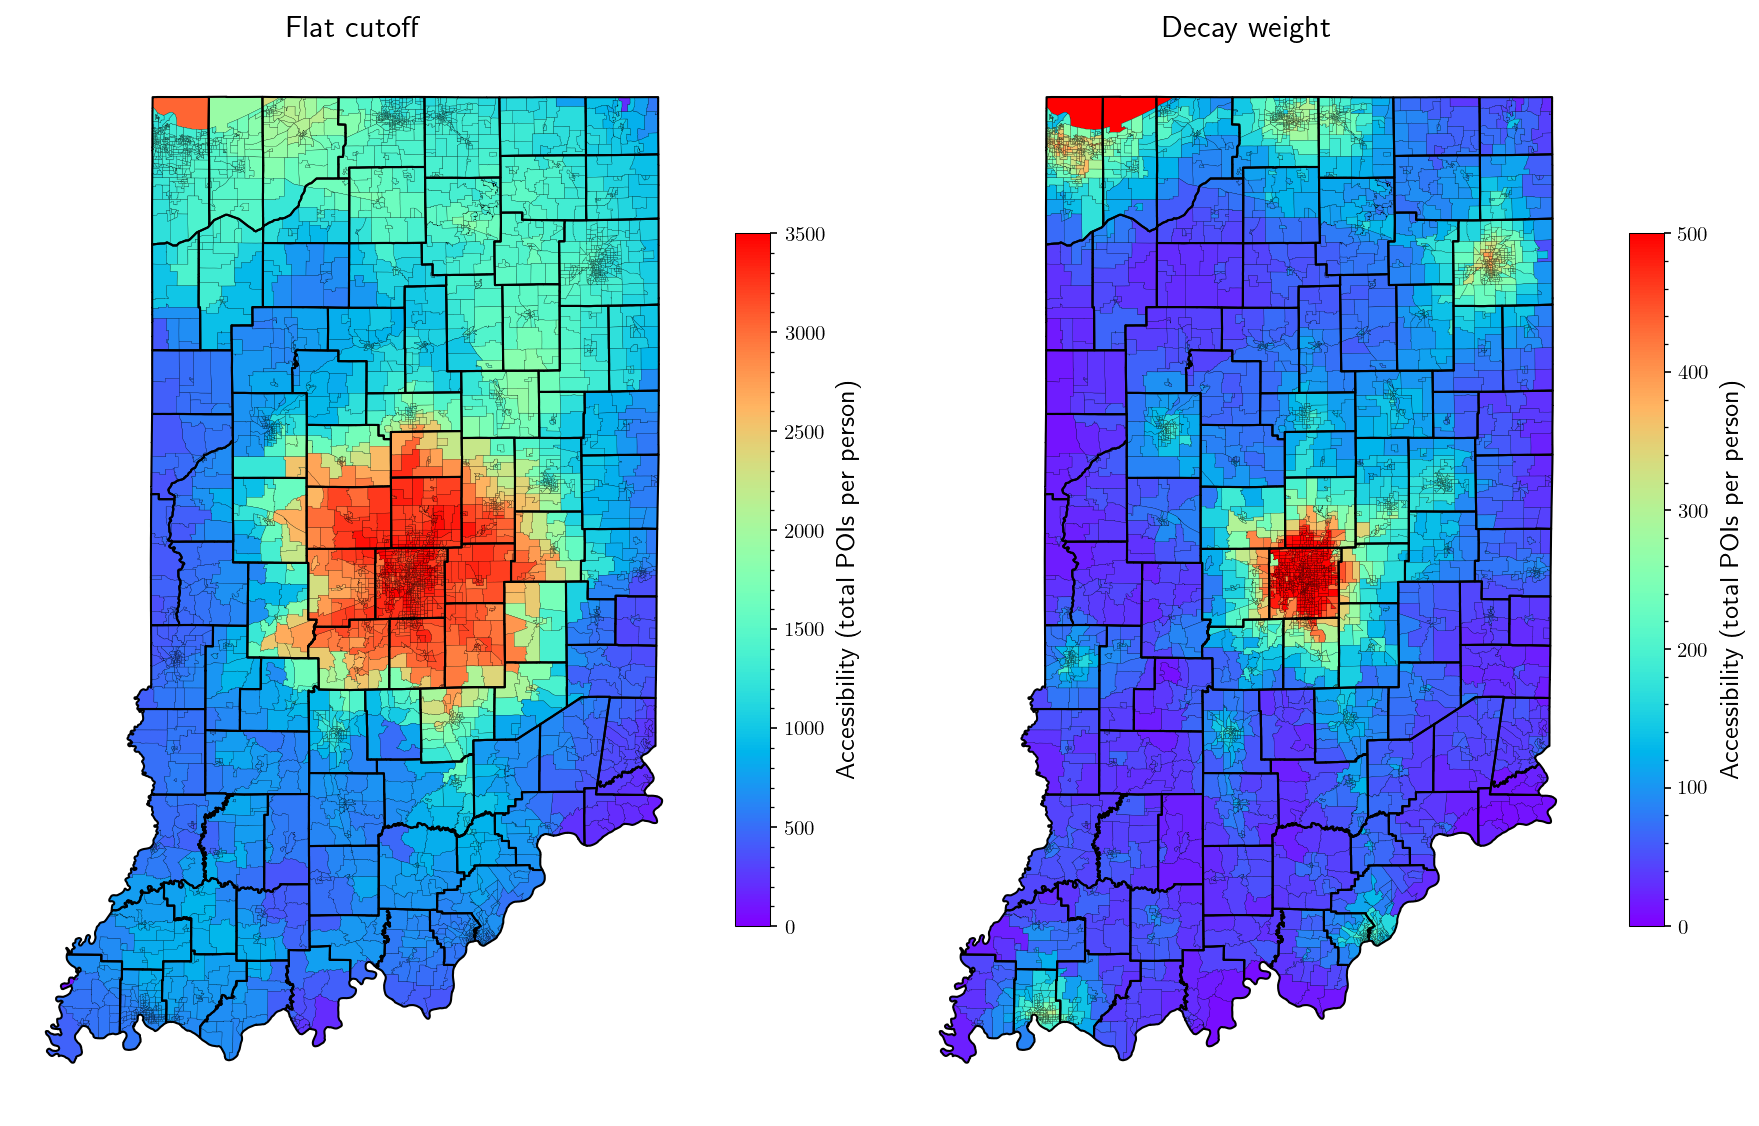

In [13]:
_, axes = plt.subplots(1, 2, figsize=(12, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, zones[['geoid','geometry','scale']]
                             .merge(xs.query('~per_person & mode=="DRIVE" & thresh=="60" & kind=="Essential"'),
                                    on='geoid').groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.to_crs(CRS_M).plot(ax=ax, column='access', legend=True, cmap='rainbow',
                         vmin=0, vmax=500 if wt_decay else 3500, ec='k', lw=0.1, legend_kwds=dict(
                             shrink=0.6, label='Accessibility (total POIs per person)'))
    zones.query('scale=="COUNTY"').to_crs(CRS_M).plot(ax=ax, ec='k', lw=1, fc='none')
    # break
plt.tight_layout()

In [14]:
xs.query('purpose=="Overall" & kind=="Overall" & wt_decay').pivot_table('access', 'geoid', 'per_person').corr()

per_person,False,True
per_person,,
False,1.000000,0.140151
True,0.140151,1.000000


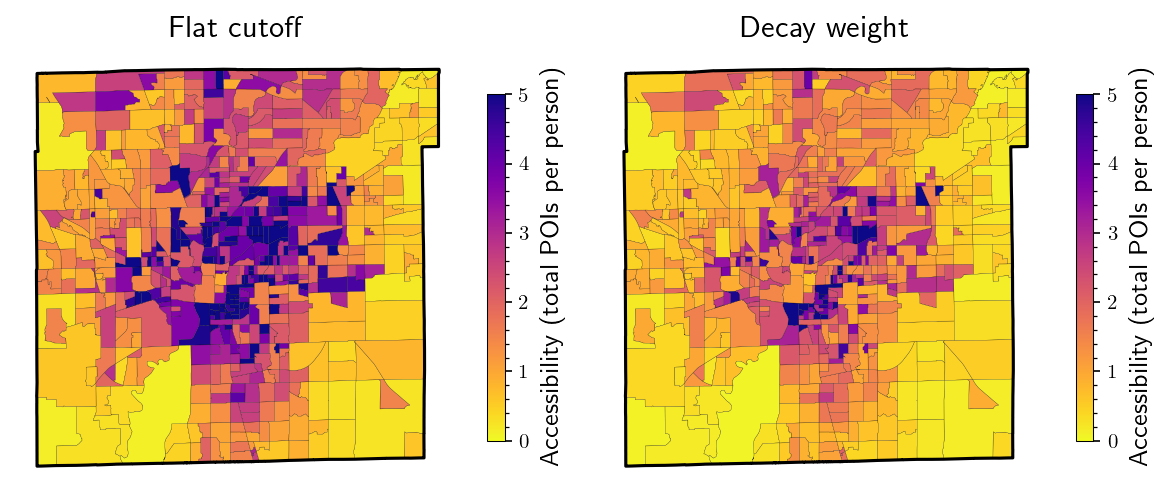

In [15]:
d2 = zones.merge(df[(df.geoid.str.len()==12) & (df.geoid.str.startswith('18097'))]).to_crs(CRS_M)
_, axes = plt.subplots(1, 2, figsize=(8, 8), dpi=150)
for ax, (wt_decay, d) in zip(axes, d2.groupby('wt_decay')):
    ax = U.plot(ax, title='Decay weight' if wt_decay else 'Flat cutoff', axoff=1)
    d.plot(ax=ax, column='access', legend=True, cmap='plasma_r',
           vmin=0, vmax=5, ec='k', lw=0.1, legend_kwds=dict(
               shrink=0.3, label='Accessibility (total POIs per person)'))
    d.dissolve().plot(ax=ax, fc='none', ec='k', lw=1.5)
plt.tight_layout()

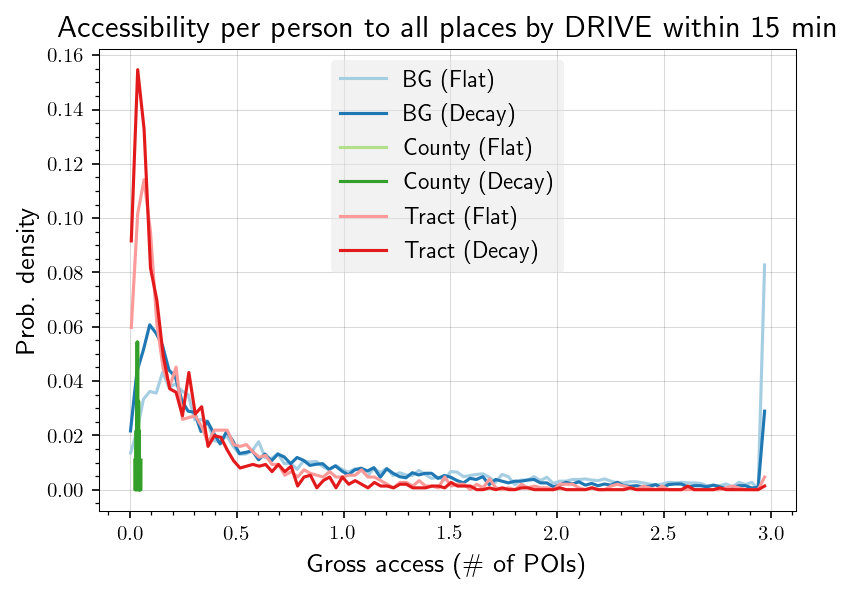

In [16]:
ax = U.plot(size=(6, 4), xlab='Gross access (\# of POIs)', ylab='Prob. density',
            title='Accessibility per person to all places by DRIVE within 15 min')
d2 = df.assign(scale=df.geoid.str.len().map({5: 'County', 11: 'Tract', 12: 'BG'}))
colors = iter(sns.color_palette('Paired', 6))
for (scale, wt_decay), d3 in d2.groupby(['scale', 'wt_decay']):
    y, x = np.histogram(d3.access.clip(0, 3), bins=100)
    ax.plot(x[:-1], y / y.sum(), lw=1.5, color=next(colors),
            label=f'{scale} ({"Decay" if wt_decay else "Flat"})')
ax.legend();

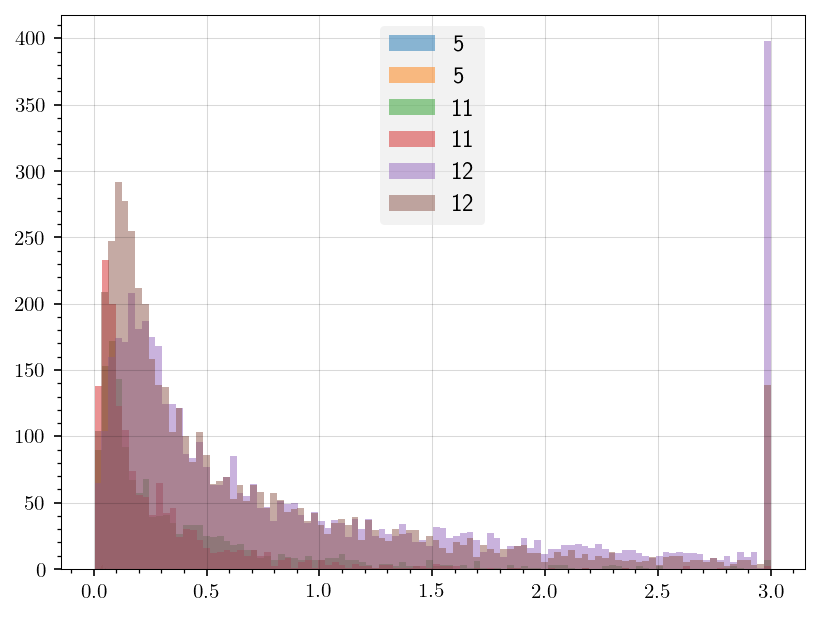

In [17]:
((df.assign(scale=df.geoid.str.len(), access=df.access.clip(0, 3))
  .groupby(['scale', 'wt_decay']).access.hist(bins=100, alpha=0.5, legend=True)));

In [19]:
xs.groupby(['purpose', 'kind']).size().pipe(lambda x: x[x > 0])

purpose              kind      
Overall              Overall       511628
Services             Overall       511628
                     Primary       476952
                     Secondary     505880
Shopping             Essential     475708
                     Overall       511628
                     Specialty     475452
Social/Recreational  Food/Drink    462352
                     Overall       511628
                     Recreation    446060
                     Religious     481484
dtype: int64

In [20]:
xs['mode'].value_counts()

mode
DRIVE      1408544
BIKE       1383048
TRANSIT    1290688
WALK       1288120
Name: count, dtype: int64

In [21]:
xs.thresh.value_counts()

thresh
90    1094320
60    1092776
45    1084448
30    1068480
15    1030376
Name: count, dtype: int64

In [22]:
xs.geoid.nunique()

6407

In [23]:
xs.wt_decay.value_counts()

wt_decay
False    2685200
True     2685200
Name: count, dtype: int64

In [24]:
xs['mode'].nunique()

4

# 3. Visualize

In [25]:
def plot_map_access(scale, mode, thresh, purpose='Overall',
                    kind='Overall', wt_decay=True, xs=xs, zones=zones,
                    size=(8, 16), dpi=120, cmap='rainbow',
                    vmin=None, vmax=None):
    cnty = zones.query('scale == "COUNTY"').to_crs(CRS_M)
    zones = zones.query(f'scale=="{scale}"')[['geoid', 'geometry']]
    xs = xs.query('mode=="{}" & thresh=="{}" & purpose=="{}" & kind=="{}"'
                  .format(mode, thresh, purpose, kind))
    xs = xs[xs['wt_decay'] == wt_decay]
    # xs = (zones.merge(xs, 'left', 'geoid').to_crs(CRS_M)
    #       [['geometry', 'access']].fillna(0))
    xs = zones.merge(xs, on='geoid').to_crs(CRS_M)
    title = ('Accessibility to {} POIs ({}) at {}\n scale within {} minutes by {}'
             .format(kind.lower(), purpose, scale, thresh, mode.title()))
    ax = U.plot(size=size, dpi=dpi, axoff=1, title=title)
    xs.plot(ax=ax, column='access', cmap=cmap, legend=True,
            edgecolor='k', lw=0.1, vmin=vmin, vmax=vmax, legend_kwds=dict(
                shrink=0.4, label='Accessibility per 1000 persons'))
    cnty.plot(ax=ax, ec='k', lw=1, facecolor='none')

# plot_map_access('TRACT', 'TRANSIT', 30, vmin=0.5, vmax=5)